#### Bitcoin price prediction

In [165]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
import os

#### Import data
https://www.investing.com/crypto/bitcoin/historical-data

2010-07-18 - 10/24/2023

Data: Daily Historical price of Bitcoin over the past 23 years

Vol: the sum of all buy-sell transactions on a daily basis

In [166]:
data_df = pd.read_csv(
    'Bitcoin Historical Data(1).csv',
    parse_dates=['Date'],
    index_col=['Date']
)
data_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-10-24,"34,562.9","33,037.3","35,191.4","32,866.5",183.50K,4.60%
2023-10-23,"33,041.8","29,984.2","34,375.6","29,891.4",133.46K,10.20%
2023-10-22,"29,984.2","29,912.7","30,193.4","29,713.6",29.07K,0.24%
2023-10-21,"29,912.9","29,674.7","30,264.8","29,469.1",34.68K,0.80%
2023-10-20,"29,674.5","28,724.0","30,165.9","28,586.1",82.68K,3.31%


In [167]:
data_df.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%
2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%
2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%
2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%
2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%


In [168]:
# order the data by date
data_df.sort_index(inplace=True)
data_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%
2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%
2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%
2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%
2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%


In [169]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4847 entries, 2010-07-18 to 2023-10-24
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     4847 non-null   object
 1   Open      4847 non-null   object
 2   High      4847 non-null   object
 3   Low       4847 non-null   object
 4   Vol.      4841 non-null   object
 5   Change %  4847 non-null   object
dtypes: object(6)
memory usage: 265.1+ KB


In [170]:
data_df.describe()

,Price,Open,High,Low,Vol.,Change %
count,4847,4847,4847,4847,4841,4847
unique,3893,3885,3880,3890,4309,1537
top,0.1,0.1,0.1,0.1,1.05M,0.00%
freq,100,100,97,101,6,428


### preprocess data

In [171]:
def remove_colon(number):
    """
    remove column in the price value and convert it to float
    example of number to convert: 34,562.9
    args:
        number: the number to convert
    """
    new_number = ''
    for i in number:
        if i == ',':
            continue
        else:
            new_number += i            
    return float(new_number)

In [172]:
data_df.Price = data_df.Price.apply(remove_colon)
data_df.Open = data_df.Open.apply(remove_colon)
data_df.High = data_df.High.apply(remove_colon)
data_df.Low = data_df.Low.apply(remove_colon)
# data_df['Vol.'] = data_df['Vol.'].apply(remove_k_and_add_000)

#### Visualize the data

In [173]:
data_df.dtypes

Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object

<AxesSubplot: xlabel='Date'>

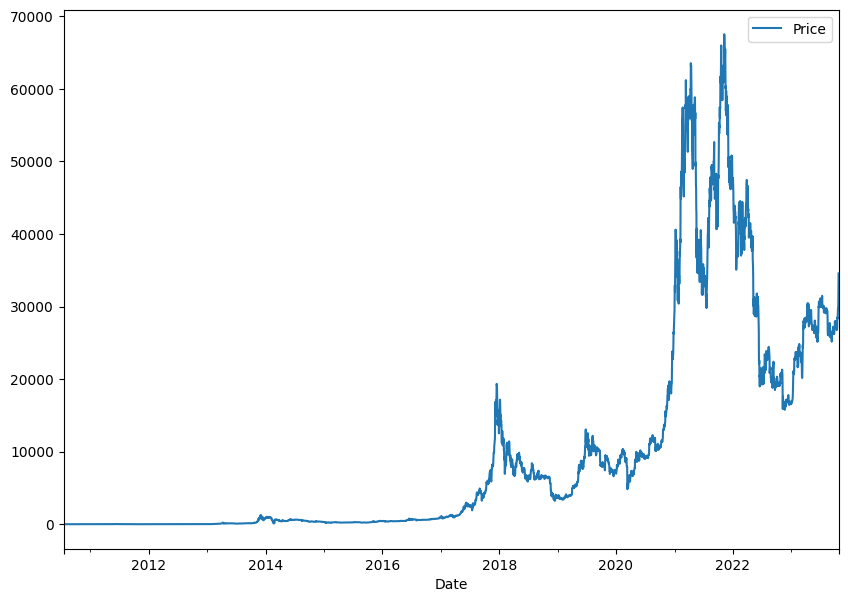

In [174]:
# Evolution of the price of bitcoin overtime

timestamps_price_df = data_df[['Price']]
timestamps_price_df.plot(figsize=(10, 7))

#### Split the data into train and test set

In [175]:
split_size = int(0.8 * data_df.shape[0])

# x_train and y_train
x_train, y_train = timestamps_price_df.index[:split_size], timestamps_price_df.Price[:split_size]

# x_test and y_test
x_test, y_test = timestamps_price_df.index[split_size:], timestamps_price_df.Price[split_size:]

In [176]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3877,), (3877,), (970,), (970,))

In [177]:
# visualize train and test data
def plot_times_series(timesteps, values, format='.', start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values
    args:
    timesteps: array of timestep values
    values: array of values accros time
    format: style of plot, default = '.'
    start: where to start the plot
    end: where to end the plot
    label: label to show on plot about values, default None
    """
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('BTC Price')
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

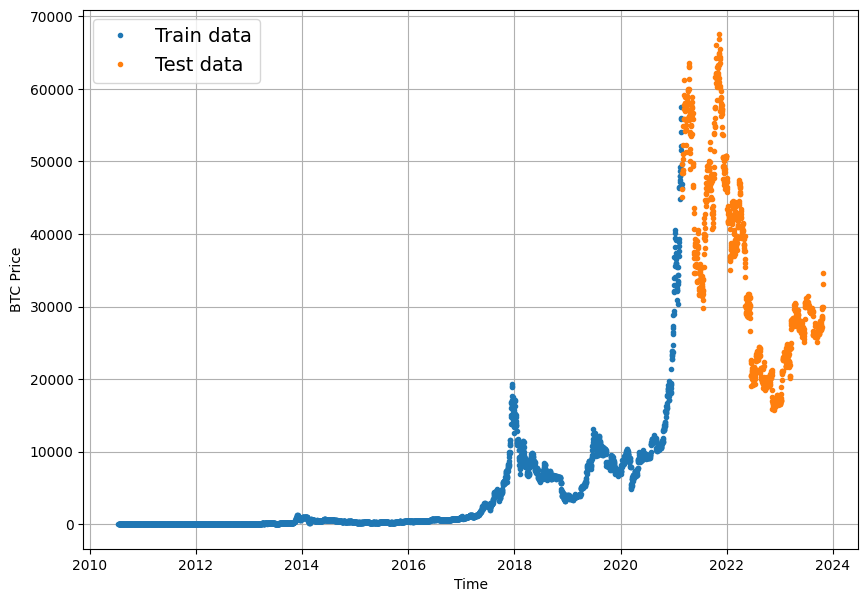

In [178]:
plt.figure(figsize=(10, 7))
plot_times_series(timesteps=x_train, values=y_train, label='Train data')
plot_times_series(timesteps=x_test, values=y_test, label='Test data')

#### Modeling

    - Horizon = number of timesteps into the future we are going to predict
    - Window size = number of timesteps er are going to use to predict horizon

#### Model 0: Naive forecast (baseline)

> The prediction at timestep t is equal to the value at timestep t-1 (previous) timestep (this for horizon=1)

In [179]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implementation MASE (assuming no seasonality of data)
    """
    mae = tf.reduce_mean(tf.abs(y_true, y_pred))
    
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    
    return mae / mae_naive_no_season

def evaluate_predictions(y_true, y_pred):
    # Make sur float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    # Account for different sized metrics(for longer horizon)
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
    return {
        'mae': mae.numpy(),
        'mse': mse.numpy(),
        'rmse': rmse.numpy(),
        'mape': mape.numpy(),
        'mase': mase.numpy() 
    }

#### Windowing our dataset
Window time series dataset to turn it into a supervised learning problem.

```
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

tf.keras.preprocessing.timeseries_dataset_from_array()

In [180]:
HORIZON = 1
WINDOW_SISE = 7

def get_labelled_window(x, horizon=HORIZON):
    """
    create labels for windowed dataset
    
    eg: for horizon=1
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
    """
    return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size=WINDOW_SISE, horizon=HORIZON):
    """
    Turn a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels
    """
    # create a window of specific window_size (add howizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    # create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon-1)), axis=0).T   
    # index on the target array (a time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    # get the labelled windows
    windows, labels = get_labelled_window(windowed_array, horizon=horizon)
    return windows, labels

def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits
    """
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [181]:
full_windows, full_labels = make_windows(timestamps_price_df.Price.values, WINDOW_SISE, HORIZON)

In [182]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3872, 968, 3872, 968)

In [183]:
# to save the model where the val loss is the lowest as the model fluctuate
def create_model_checkpoint(model_name, save_path='model_experiments'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

#### Model 1: Dense model (window = 7, horizon = 1)

In [184]:
# set random seed for as reproductible results as possible
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON, activation='linear')
], name='model_1')

model_1.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae', 'mse']
)

history_1 = model_1.fit(
    x=train_windows,
    y=train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_1.name)]
)

Epoch 1/100
29/31 [===========================>..] - ETA: 0s - loss: 1526.5247 - mae: 1526.5247 - mse: 15820343.0000

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 2s 46ms/step - loss: 1482.6040 - mae: 1482.6040 - mse: 15228855.0000 - val_loss: 2758.4539 - val_mae: 2758.4539 - val_mse: 12619706.0000
Epoch 2/100
30/31 [============================>.] - ETA: 0s - loss: 277.1995 - mae: 277.1995 - mse: 604735.6250

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 31ms/step - loss: 277.8146 - mae: 277.8146 - mse: 604237.7500 - val_loss: 1685.9353 - val_mae: 1685.9353 - val_mse: 5717478.0000
Epoch 3/100
27/31 [=========================>....] - ETA: 0s - loss: 234.0907 - mae: 234.0907 - mse: 508724.4375 

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 30ms/step - loss: 231.0564 - mae: 231.0564 - mse: 487849.1250 - val_loss: 1664.2017 - val_mae: 1664.2017 - val_mse: 5645102.0000
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 214.7227 - mae: 214.7227 - mse: 402943.0625 - val_loss: 1744.5961 - val_mae: 1744.5961 - val_mse: 5886911.0000
Epoch 5/100
 1/31 [..............................] - ETA: 0s - loss: 277.0590 - mae: 277.0590 - mse: 1023440.0000

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 27ms/step - loss: 207.0147 - mae: 207.0147 - mse: 386061.3438 - val_loss: 1376.1769 - val_mae: 1376.1769 - val_mse: 4073003.0000
Epoch 6/100
28/31 [==========================>...] - ETA: 0s - loss: 192.2868 - mae: 192.2868 - mse: 337647.4375

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 31ms/step - loss: 193.8807 - mae: 193.8807 - mse: 339750.0938 - val_loss: 1304.2178 - val_mae: 1304.2178 - val_mse: 3676497.7500
Epoch 7/100
25/31 [=======================>......] - ETA: 0s - loss: 189.9548 - mae: 189.9548 - mse: 335906.6250

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 25ms/step - loss: 183.8621 - mae: 183.8621 - mse: 305833.3438 - val_loss: 1213.0630 - val_mae: 1213.0630 - val_mse: 3148582.2500
Epoch 8/100
 1/31 [..............................] - ETA: 0s - loss: 153.4250 - mae: 153.4250 - mse: 192094.0312

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 26ms/step - loss: 179.2832 - mae: 179.2832 - mse: 271550.1875 - val_loss: 1146.0044 - val_mae: 1146.0044 - val_mse: 2800153.7500
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 163.4532 - mae: 163.4532 - mse: 249244.5938 - val_loss: 1149.3097 - val_mae: 1149.3097 - val_mse: 2824241.7500
Epoch 10/100
28/31 [==========================>...] - ETA: 0s - loss: 160.7141 - mae: 160.7141 - mse: 233941.3906

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 27ms/step - loss: 158.3869 - mae: 158.3869 - mse: 224273.3906 - val_loss: 1098.0215 - val_mae: 1098.0215 - val_mse: 2589811.5000
Epoch 11/100
28/31 [==========================>...] - ETA: 0s - loss: 160.2742 - mae: 160.2742 - mse: 229132.0312

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 25ms/step - loss: 159.9152 - mae: 159.9152 - mse: 226921.5312 - val_loss: 1093.7572 - val_mae: 1093.7572 - val_mse: 2449037.5000
Epoch 12/100
31/31 [==============================] - ETA: 0s - loss: 146.1281 - mae: 146.1281 - mse: 194211.8750

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 25ms/step - loss: 146.1281 - mae: 146.1281 - mse: 194211.8750 - val_loss: 1027.7563 - val_mae: 1027.7563 - val_mse: 2262976.7500
Epoch 13/100
29/31 [===========================>..] - ETA: 0s - loss: 144.0883 - mae: 144.0883 - mse: 194062.5000

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 26ms/step - loss: 141.5719 - mae: 141.5719 - mse: 187467.3906 - val_loss: 1025.5530 - val_mae: 1025.5530 - val_mse: 2281022.5000
Epoch 14/100
31/31 [==============================] - 0s 5ms/step - loss: 141.2914 - mae: 141.2914 - mse: 187907.3594 - val_loss: 1108.7115 - val_mae: 1108.7115 - val_mse: 2560464.7500
Epoch 15/100
31/31 [==============================] - 0s 4ms/step - loss: 133.0689 - mae: 133.0689 - mse: 167506.9531 - val_loss: 1033.7700 - val_mae: 1033.7700 - val_mse: 2290217.7500
Epoch 16/100
 1/31 [..............................] - ETA: 0s - loss: 179.7226 - mae: 179.7226 - mse: 441744.6875

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 24ms/step - loss: 139.2595 - mae: 139.2595 - mse: 181469.3750 - val_loss: 960.9663 - val_mae: 960.9663 - val_mse: 2031205.8750
Epoch 17/100
31/31 [==============================] - 0s 4ms/step - loss: 134.0302 - mae: 134.0302 - mse: 166991.4375 - val_loss: 1117.6106 - val_mae: 1117.6106 - val_mse: 2400967.5000
Epoch 18/100
31/31 [==============================] - 0s 3ms/step - loss: 133.1344 - mae: 133.1344 - mse: 166619.4688 - val_loss: 988.6407 - val_mae: 988.6407 - val_mse: 2032091.0000
Epoch 19/100
31/31 [==============================] - 0s 4ms/step - loss: 140.0533 - mae: 140.0533 - mse: 165014.4688 - val_loss: 1128.5593 - val_mae: 1128.5593 - val_mse: 2413942.5000
Epoch 20/100
31/31 [==============================] - 0s 3ms/step - loss: 134.2169 - mae: 134.2169 - mse: 173779.3125 - val_loss: 1027.0038 - val_mae: 1027.0038 - val_mse: 2227384.5000
Epoch 21/100
31/31 [==============================] - 0s 3ms/step - loss: 146.0741 - mae: 1

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 24ms/step - loss: 125.0131 - mae: 125.0131 - mse: 148209.8438 - val_loss: 958.9791 - val_mae: 958.9791 - val_mse: 2013189.2500
Epoch 23/100
25/31 [=======================>......] - ETA: 0s - loss: 121.8552 - mae: 121.8552 - mse: 157808.2031

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 32ms/step - loss: 122.3827 - mae: 122.3827 - mse: 152098.0938 - val_loss: 958.9023 - val_mae: 958.9023 - val_mse: 2008027.3750
Epoch 24/100
31/31 [==============================] - 0s 4ms/step - loss: 123.0136 - mae: 123.0136 - mse: 152108.9531 - val_loss: 973.0495 - val_mae: 973.0495 - val_mse: 1964874.5000
Epoch 25/100
29/31 [===========================>..] - ETA: 0s - loss: 121.9586 - mae: 121.9586 - mse: 143224.1562

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 30ms/step - loss: 122.7377 - mae: 122.7377 - mse: 145498.4375 - val_loss: 897.3157 - val_mae: 897.3157 - val_mse: 1796655.6250
Epoch 26/100
18/31 [================>.............] - ETA: 0s - loss: 120.6717 - mae: 120.6717 - mse: 151321.4688

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 28ms/step - loss: 119.9148 - mae: 119.9148 - mse: 141390.4062 - val_loss: 883.5554 - val_mae: 883.5554 - val_mse: 1788916.8750
Epoch 27/100
31/31 [==============================] - 0s 4ms/step - loss: 130.0167 - mae: 130.0167 - mse: 160761.0938 - val_loss: 895.4783 - val_mae: 895.4783 - val_mse: 1784271.6250
Epoch 28/100
31/31 [==============================] - 0s 4ms/step - loss: 119.6674 - mae: 119.6674 - mse: 142889.2969 - val_loss: 1255.8582 - val_mae: 1255.8582 - val_mse: 2916254.7500
Epoch 29/100
31/31 [==============================] - 0s 4ms/step - loss: 123.5378 - mae: 123.5378 - mse: 141599.9062 - val_loss: 910.4644 - val_mae: 910.4644 - val_mse: 1858558.3750
Epoch 30/100
29/31 [===========================>..] - ETA: 0s - loss: 126.3004 - mae: 126.3004 - mse: 148439.3438

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 28ms/step - loss: 125.6227 - mae: 125.6227 - mse: 145678.1875 - val_loss: 880.6219 - val_mae: 880.6219 - val_mse: 1778922.7500
Epoch 31/100
28/31 [==========================>...] - ETA: 0s - loss: 125.6072 - mae: 125.6072 - mse: 148822.8125

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 28ms/step - loss: 124.2722 - mae: 124.2722 - mse: 143208.2656 - val_loss: 877.5756 - val_mae: 877.5756 - val_mse: 1740546.2500
Epoch 32/100
27/31 [=========================>....] - ETA: 0s - loss: 120.0985 - mae: 120.0985 - mse: 141025.1719

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 30ms/step - loss: 119.6474 - mae: 119.6474 - mse: 141916.4062 - val_loss: 858.7725 - val_mae: 858.7725 - val_mse: 1716557.1250
Epoch 33/100
31/31 [==============================] - 0s 5ms/step - loss: 117.0894 - mae: 117.0894 - mse: 138176.5781 - val_loss: 862.2036 - val_mae: 862.2036 - val_mse: 1729461.1250
Epoch 34/100
24/31 [======================>.......] - ETA: 0s - loss: 123.0105 - mae: 123.0105 - mse: 138754.7656

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 3s 95ms/step - loss: 124.2783 - mae: 124.2783 - mse: 148304.4844 - val_loss: 856.4183 - val_mae: 856.4183 - val_mse: 1700742.2500
Epoch 35/100
25/31 [=======================>......] - ETA: 0s - loss: 131.4631 - mae: 131.4631 - mse: 164909.6875

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 24ms/step - loss: 126.9653 - mae: 126.9653 - mse: 149488.6719 - val_loss: 850.8156 - val_mae: 850.8156 - val_mse: 1698407.1250
Epoch 36/100
31/31 [==============================] - 0s 5ms/step - loss: 123.9835 - mae: 123.9835 - mse: 145263.5156 - val_loss: 1091.3000 - val_mae: 1091.3000 - val_mse: 2257632.2500
Epoch 37/100
31/31 [==============================] - 0s 3ms/step - loss: 124.1627 - mae: 124.1627 - mse: 143802.4688 - val_loss: 887.2029 - val_mae: 887.2029 - val_mse: 1748140.0000
Epoch 38/100
31/31 [==============================] - 0s 4ms/step - loss: 117.4892 - mae: 117.4892 - mse: 138621.4688 - val_loss: 856.3626 - val_mae: 856.3626 - val_mse: 1693441.2500
Epoch 39/100
31/31 [==============================] - 0s 4ms/step - loss: 129.6201 - mae: 129.6201 - mse: 148467.9062 - val_loss: 1278.0979 - val_mae: 1278.0979 - val_mse: 2950557.5000
Epoch 40/100
31/31 [==============================] - 0s 4ms/step - loss: 117.5401 - mae: 117

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 33ms/step - loss: 118.7169 - mae: 118.7169 - mse: 139699.0469 - val_loss: 840.5868 - val_mae: 840.5868 - val_mse: 1667929.7500
Epoch 43/100
31/31 [==============================] - 0s 5ms/step - loss: 115.2115 - mae: 115.2115 - mse: 133775.0312 - val_loss: 841.3300 - val_mae: 841.3300 - val_mse: 1666552.3750
Epoch 44/100
31/31 [==============================] - 0s 5ms/step - loss: 114.6043 - mae: 114.6043 - mse: 133053.0312 - val_loss: 863.1097 - val_mae: 863.1097 - val_mse: 1728627.8750
Epoch 45/100
31/31 [==============================] - 0s 7ms/step - loss: 114.0111 - mae: 114.0111 - mse: 129574.5312 - val_loss: 877.9041 - val_mae: 877.9041 - val_mse: 1725173.5000
Epoch 46/100
31/31 [==============================] - 0s 4ms/step - loss: 116.3704 - mae: 116.3704 - mse: 134938.3906 - val_loss: 851.3730 - val_mae: 851.3730 - val_mse: 1677212.3750
Epoch 47/100
31/31 [==============================] - 0s 5ms/step - loss: 127.8439 - mae: 127.843

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 31ms/step - loss: 113.3694 - mae: 113.3694 - mse: 126776.8281 - val_loss: 835.2715 - val_mae: 835.2715 - val_mse: 1650082.0000
Epoch 54/100
31/31 [==============================] - 0s 7ms/step - loss: 116.8548 - mae: 116.8548 - mse: 135342.2188 - val_loss: 836.5182 - val_mae: 836.5182 - val_mse: 1666739.7500
Epoch 55/100
31/31 [==============================] - 0s 3ms/step - loss: 115.7749 - mae: 115.7749 - mse: 130401.5391 - val_loss: 847.7432 - val_mae: 847.7432 - val_mse: 1669014.8750
Epoch 56/100
28/31 [==========================>...] - ETA: 0s - loss: 115.6190 - mae: 115.6190 - mse: 138674.9688

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 31ms/step - loss: 115.4291 - mae: 115.4291 - mse: 134023.0625 - val_loss: 828.3756 - val_mae: 828.3756 - val_mse: 1639863.7500
Epoch 57/100
31/31 [==============================] - 0s 4ms/step - loss: 117.1685 - mae: 117.1685 - mse: 132407.6406 - val_loss: 890.0950 - val_mae: 890.0950 - val_mse: 1780721.3750
Epoch 58/100
24/31 [======================>.......] - ETA: 0s - loss: 122.7328 - mae: 122.7328 - mse: 143388.9844

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 29ms/step - loss: 116.7974 - mae: 116.7974 - mse: 129114.7500 - val_loss: 824.3288 - val_mae: 824.3288 - val_mse: 1636055.3750
Epoch 59/100
31/31 [==============================] - 0s 5ms/step - loss: 116.5433 - mae: 116.5433 - mse: 133840.7500 - val_loss: 891.4944 - val_mae: 891.4944 - val_mse: 1753439.8750
Epoch 60/100
31/31 [==============================] - 0s 4ms/step - loss: 117.7765 - mae: 117.7765 - mse: 131135.2031 - val_loss: 827.5481 - val_mae: 827.5481 - val_mse: 1637560.3750
Epoch 61/100
31/31 [==============================] - 0s 4ms/step - loss: 115.9826 - mae: 115.9826 - mse: 133877.6406 - val_loss: 953.6785 - val_mae: 953.6785 - val_mse: 1933998.3750
Epoch 62/100
31/31 [==============================] - 0s 4ms/step - loss: 131.7530 - mae: 131.7530 - mse: 143826.9531 - val_loss: 842.7072 - val_mae: 842.7072 - val_mse: 1675581.2500
Epoch 63/100
31/31 [==============================] - 0s 4ms/step - loss: 131.9887 - mae: 131.988

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 32ms/step - loss: 132.1883 - mae: 132.1883 - mse: 145246.0156 - val_loss: 823.6282 - val_mae: 823.6282 - val_mse: 1633256.1250
Epoch 69/100
31/31 [==============================] - 0s 5ms/step - loss: 112.2672 - mae: 112.2672 - mse: 123725.6094 - val_loss: 1357.4146 - val_mae: 1357.4146 - val_mse: 3091089.2500
Epoch 70/100
31/31 [==============================] - 0s 6ms/step - loss: 126.5047 - mae: 126.5047 - mse: 141504.9844 - val_loss: 824.2325 - val_mae: 824.2325 - val_mse: 1635464.6250
Epoch 71/100
31/31 [==============================] - 0s 5ms/step - loss: 113.1675 - mae: 113.1675 - mse: 123922.7422 - val_loss: 870.1339 - val_mae: 870.1339 - val_mse: 1709428.1250
Epoch 72/100
31/31 [==============================] - 0s 4ms/step - loss: 117.4301 - mae: 117.4301 - mse: 135139.1250 - val_loss: 869.9363 - val_mae: 869.9363 - val_mse: 1709136.1250
Epoch 73/100
31/31 [==============================] - 0s 7ms/step - loss: 121.0909 - mae: 121.0

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 32ms/step - loss: 114.8747 - mae: 114.8747 - mse: 126417.3047 - val_loss: 822.9163 - val_mae: 822.9163 - val_mse: 1628532.8750
Epoch 80/100
31/31 [==============================] - 0s 5ms/step - loss: 115.3058 - mae: 115.3058 - mse: 129133.2656 - val_loss: 983.6432 - val_mae: 983.6432 - val_mse: 1961561.6250
Epoch 81/100
31/31 [==============================] - 0s 4ms/step - loss: 118.4484 - mae: 118.4484 - mse: 127209.9688 - val_loss: 842.1611 - val_mae: 842.1611 - val_mse: 1653940.6250
Epoch 82/100
31/31 [==============================] - 0s 5ms/step - loss: 118.6451 - mae: 118.6451 - mse: 137798.2344 - val_loss: 902.2649 - val_mae: 902.2649 - val_mse: 1802331.3750
Epoch 83/100
31/31 [==============================] - 0s 5ms/step - loss: 113.4282 - mae: 113.4282 - mse: 127937.5625 - val_loss: 899.9152 - val_mae: 899.9152 - val_mse: 1797319.5000
Epoch 84/100
31/31 [==============================] - 0s 4ms/step - loss: 116.6050 - mae: 116.605

INFO:tensorflow:Assets written to: model_experiments\model_1\assets


INFO:tensorflow:Assets written to: model_experiments\model_1\assets


31/31 [==============================] - 1s 27ms/step - loss: 119.2284 - mae: 119.2284 - mse: 133437.8906 - val_loss: 819.4719 - val_mae: 819.4719 - val_mse: 1620772.0000
Epoch 89/100
31/31 [==============================] - 0s 6ms/step - loss: 110.6365 - mae: 110.6365 - mse: 124676.7656 - val_loss: 831.7011 - val_mae: 831.7011 - val_mse: 1634565.0000
Epoch 90/100
31/31 [==============================] - 0s 4ms/step - loss: 115.2696 - mae: 115.2696 - mse: 128428.0625 - val_loss: 820.1982 - val_mae: 820.1982 - val_mse: 1620053.2500
Epoch 91/100
31/31 [==============================] - 0s 4ms/step - loss: 111.7015 - mae: 111.7015 - mse: 123989.6797 - val_loss: 885.6192 - val_mae: 885.6192 - val_mse: 1736326.0000
Epoch 92/100
31/31 [==============================] - 0s 4ms/step - loss: 116.0741 - mae: 116.0741 - mse: 126498.6094 - val_loss: 853.1979 - val_mae: 853.1979 - val_mse: 1671095.3750
Epoch 93/100
31/31 [==============================] - 0s 7ms/step - loss: 118.6510 - mae: 118.651

In [185]:
model_1_loaded = tf.keras.models.load_model('model_experiments/model_1/')

In [186]:
model_1_loaded.evaluate(test_windows, test_labels)

31/31 [==============================] - 0s 3ms/step - loss: 819.4719 - mae: 819.4719 - mse: 1620772.0000


[819.4718627929688, 819.4718627929688, 1620772.0]

In [187]:
def make_preds(model, input_data):
    """
    Use model to make predictions input_data
    """
    forecast = model.predict(input_data)
    
    return  tf.squeeze(forecast)

In [188]:
model_1_loaded_preds = make_preds(model_1_loaded, test_windows)

31/31 [==============================] - 0s 2ms/step


In [189]:
model_1_results = evaluate_predictions(tf.squeeze(test_labels), model_1_loaded_preds)

In [190]:
model_1_results

{'mae': 819.472,
 'mse': 1620771.8,
 'rmse': 1273.0953,
 'mape': 2.2836134,
 'mase': 42.008}

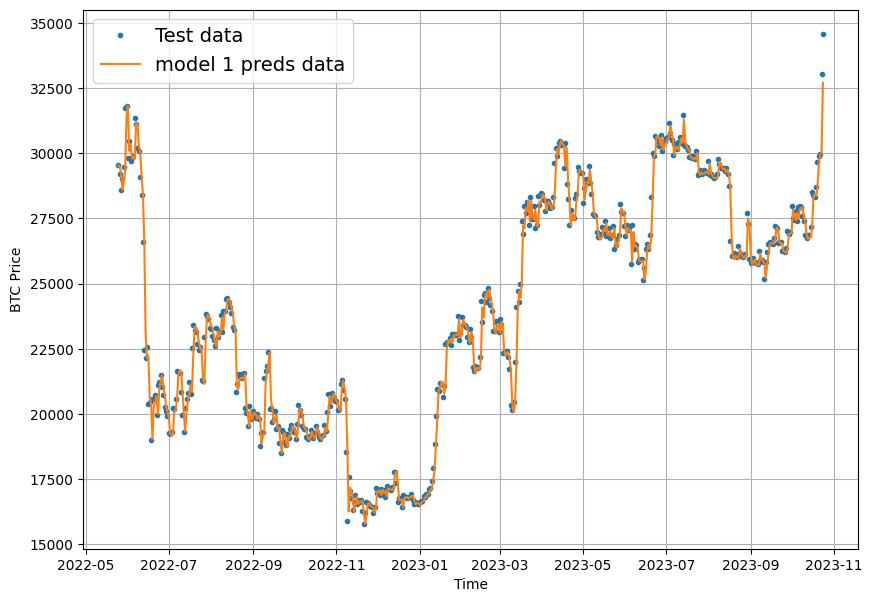

In [191]:
offset = 450
plt.figure(figsize=(10, 7))
plot_times_series(timesteps=x_test[-len(test_windows):],
                  values=test_labels[:, 0],
                  start=offset,
                  label='Test data')

plot_times_series(timesteps=x_test[-len(test_windows):],
                  values=model_1_loaded_preds,
                  start=offset,
                  format='-',
                  label='model 1 preds data')

#### Conv 1D

In [192]:
# expand dimension
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [193]:
tf.random.set_seed(42)
model_2 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='causal', activation='relu'),
    tf.keras.layers.Dense(HORIZON)
], name='model_2_conv1D')

model_2.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae', 'mse']
)

history_2 = model_2.fit(
    x=train_windows,
    y=train_labels,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_2.name)]
)

INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_conv1D\assets


In [194]:
model_2_loaded = tf.keras.models.load_model('model_experiments/model_2_conv1D/')
model_2_loaded.evaluate(test_windows, test_labels)

31/31 [==============================] - 0s 2ms/step - loss: 823.6212 - mae: 823.6212 - mse: 1640675.1250


[823.6212158203125, 823.6212158203125, 1640675.125]

In [195]:
model_2_preds = make_preds(model_2_loaded, test_windows)

31/31 [==============================] - 0s 1ms/step


In [196]:
model_2_res = evaluate_predictions(test_labels, model_2_preds)
model_2_res

{'mae': 14683.485,
 'mse': 340888350.0,
 'rmse': 17884.562,
 'mape': 47.56548,
 'mase': 42.008}

#### Multivariate time series dataset

In [197]:
data_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%
2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%
2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%
2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%
2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%


In [198]:
timestamps_price_high_low_df = data_df[['Price', 'High', 'Low']]
timestamps_price_high_low_df.head()

,Price,High,Low
Date,,,
2010-07-18,0.1,0.1,0.1
2010-07-19,0.1,0.1,0.1
2010-07-20,0.1,0.1,0.1
2010-07-21,0.1,0.1,0.1
2010-07-22,0.1,0.1,0.1


<AxesSubplot: xlabel='Date'>

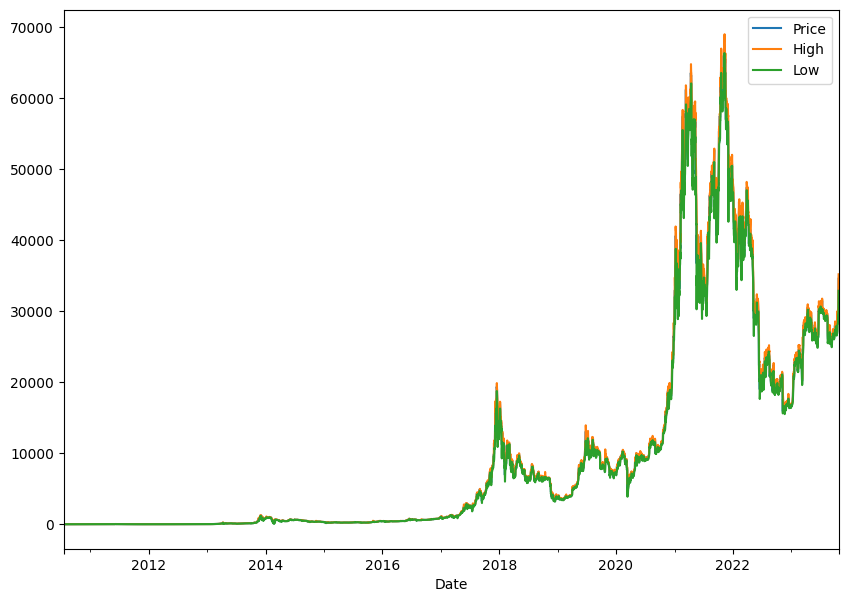

In [199]:
timestamps_price_high_low_df.plot(figsize=(10, 7))

In [200]:
# making a windowed dataset with pandas.
bitcoin_prices_windowed = timestamps_price_high_low_df.copy()

# Add windowed columns
for i in range(WINDOW_SISE):
    bitcoin_prices_windowed[[f'Price+{i+1}', f'High+{i+1}']] = bitcoin_prices_windowed[['Price', 'High']].shift(periods=i+1)
    
bitcoin_prices_windowed.head(10)

,Price,High,Low,Price+1,High+1,Price+2,High+2,Price+3,High+3,Price+4,High+4,Price+5,High+5,Price+6,High+6,Price+7,High+7
Date,,,,,,,,,,,,,,,,,
2010-07-18,0.1,0.1,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-19,0.1,0.1,0.1,0.1,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-20,0.1,0.1,0.1,0.1,0.1,0.1,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-21,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-22,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-23,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,NaN,NaN,NaN,NaN
2010-07-24,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,NaN,NaN
2010-07-25,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2010-07-26,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [201]:
x = bitcoin_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

In [202]:
x.shape, y.shape

((4840, 16), (4840,))

In [203]:
# Make train and test sets using indexing
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(x, y)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3872, 968, 3872, 968)

In [204]:
# set random seed for as reproductible results as possible
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON)
], name='model_3')

model_3.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae', 'mse']
)

history_3 = model_3.fit(
    x=train_windows,
    y=train_labels,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_3.name)]
)

INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


INFO:tensorflow:Assets written to: model_experiments\model_3\assets


In [205]:
model_3_loaded = tf.keras.models.load_model('model_experiments/model_3')
model_3_loaded.evaluate(test_windows, test_labels)

31/31 [==============================] - 0s 5ms/step - loss: 416.7764 - mae: 416.7764 - mse: 364024.9062


[416.7763671875, 416.7763671875, 364024.90625]

In [206]:
# Make prediction
model_3_preds = make_preds(model_3_loaded, test_windows)

31/31 [==============================] - 0s 1ms/step


In [207]:
model_3_res = evaluate_predictions(test_labels, model_3_preds)
model_3_res

{'mae': 416.77634,
 'mse': 364025.0,
 'rmse': 603.34485,
 'mape': 1.1653488,
 'mase': 42.008}

#### N-BEATS algorithm
https://arxiv.org/pdf/1905.10437.pdf

N-BEATS: NEURAL BASIS EXPANSION ANALYSIS FOR
INTERPRETABLE TIME SERIES FORECASTING

In [208]:
# Because the N-BEATS block layer does'nt exist in tensorflow, we've got to create it 
#To create custom layers and models in Tensorflow we can use subclassing

# create the NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                  input_size: int,
                  theta_size: int,
                  horizon: int,
                  n_neurons: int,
                  n_layers: int,
                  **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        
        # Block contains stack of 4 fully connected layers each has ReLU activation
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
        # output of block is a theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear')
        
    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        self.theta = self.theta_layer(x)
        # output the backcast and the forcast from theta
        backcast, forecast = self.theta[:, :self.input_size], self.theta[:, -self.horizon:]
        return backcast, forecast
        
        

In [209]:
# prepare data for the N-BEATS algorithm using 'tf.data' to make the input data load as fast as possible

timestamps_price_df.head()

,Price
Date,
2010-07-18,0.1
2010-07-19,0.1
2010-07-20,0.1
2010-07-21,0.1
2010-07-22,0.1


In [210]:
# Add windowed column
bitcoin_prices_nbeats = timestamps_price_df.copy()

for i in range(WINDOW_SISE):
    bitcoin_prices_nbeats[f'Price+{i+1}'] = bitcoin_prices_nbeats['Price'].shift(periods=i+1)
    
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2010-07-18,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-19,0.1,0.1,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-20,0.1,0.1,0.1,NaN,NaN,NaN,NaN,NaN
2010-07-21,0.1,0.1,0.1,0.1,NaN,NaN,NaN,NaN
2010-07-22,0.1,0.1,0.1,0.1,0.1,NaN,NaN,NaN


In [211]:
# Make features and labels
x = bitcoin_prices_nbeats.dropna().drop('Price', axis=1)
y = bitcoin_prices_nbeats.dropna()['Price']

# Make train and test sets using indexing
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(x, y)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3872, 968, 3872, 968)

In [212]:
x

,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,
2010-07-25,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2010-07-26,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2010-07-27,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2010-07-28,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2010-07-29,0.1,0.1,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...,...,...
2023-10-20,28723.0,28321.7,28403.6,28509.7,27161.2,26852.8,26863.5
2023-10-21,29674.5,28723.0,28321.7,28403.6,28509.7,27161.2,26852.8
2023-10-22,29912.9,29674.5,28723.0,28321.7,28403.6,28509.7,27161.2


In [213]:
# TIme to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(train_windows)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)

test_features_dataset = tf.data.Dataset.from_tensor_slices(test_windows)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels)

# combine labels and features by zipping together (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batching and prefech
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [214]:
# Setting up hyperparameters
N_EPOCHS = 5000 # in the paper refers to iterations
N_NEURONS = 512 # in the paper refers to width
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SISE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

In [215]:
# Get ready the residual connection
# Before we can craft N-BEATS model, we need 2 layers for the residual connections (substract and add)
# The N-BEATS algorithm uses double residual stacking to help train its deeper architechture
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)
# substract
substracted = tf.keras.layers.subtract([tensor_1, tensor_2])
# add
added = tf.keras.layers.add([tensor_1, tensor_2])

### Building, compiling and fitting the N-BEATS algo

1- Setup an instance of the N-BEATS Block layer using `NBeatsBlock` class

2- Create an input layer for the N-BEATS stack (using functional API)

3- Make the initial backcast and forecasts for the model with the layer created in 1

4 - Use for loop to create stacks of block layers

5- Use the `NBeatsBlock` class within the for loop in 4 to create blocks which return backcasts and block-level forecasts

6- Create the double residual stacking using snsract and add layers

7- Put the model inputs and outputs together using `tf.keras.Model()`

8- Compile the model

9- Fit model for 5k
    callbacks: 
        - Early stopping: (stop if the model stop improving)
        - Reduce LR on plateau: if the model stops improving, try lowering the learning rate to reduce the amounts it updates its weights each time

In [216]:
tf.random.set_seed(42)

# 1- Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name='InitialBlock')
# 2- Create an input layer for the N-BEATS stack (using functional API)
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name='stack_input')

# 3- Make the initial backcast and forecasts for the model with the layer created in 1
residuals, forecast = nbeats_block_layer(stack_input)

# 4 - Use for loop to create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)):
    # 5- Use the `NBeatsBlock` class within the for loop in 4 to create blocks which return backcasts and block-level forecasts
    backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name=f'NBeatsBlock_{i}')(residuals) # pass in the residuals
    # 6- create the double residual stacking
    residuals = tf.keras.layers.subtract([residuals, backcast], name=f'substract_{i}')
    forecast = tf.keras.layers.add([forecast, block_forecast], name=f'add_{i}')

# 7- Put the model inputs and outputs together using `tf.keras.Model()`
nbeats_model = tf.keras.Model(inputs=stack_input, outputs=forecast, name='NBeatsModel')

In [217]:
nbeats_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae', 'mse']
)

history_4 = nbeats_model.fit(
    train_dataset,
    epochs=5000,
    verbose=0,
    batch_size=128,
    validation_data=test_dataset,
    callbacks=[#create_model_checkpoint(model_name=nbeats_model.name),
               tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True), # stop if the model is not improving on the val loss in 5 epochs and restore best performing weight
               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)] )


Epoch 555: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1030: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1130: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


In [218]:
nbeats_model.evaluate(test_dataset)

1/1 [==============================] - 0s 387ms/step - loss: 826.5875 - mae: 826.5875 - mse: 1630284.5000


[826.5874633789062, 826.5874633789062, 1630284.5]

In [219]:
# Make predictions
nbeats_model_preds = make_preds(nbeats_model, test_dataset)

1/1 [==============================] - 3s 3s/step


In [220]:
nbeats_res = evaluate_predictions(test_labels, nbeats_model_preds)
nbeats_res

{'mae': 826.58746,
 'mse': 1630284.5,
 'rmse': 1276.8259,
 'mape': 2.2994082,
 'mase': 42.008}

### Creating an Ensemble (stacking different models together)

Combine different models to make a decision

fit on 3 differents metrics with different random initialization

In [221]:
# construct and fitting and ensemble of models (using different loss functions)
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset, 
                        test_data=test_dataset, 
                        num_iter=5,
                        num_epochs=1000,
                        loss_fn=['mae', 'mse', 'mape']):
    """
    Returns a list of num_iter models each trained on MAE, MSE, and MAPE loss.
    For example if num_iter=10, a list of 30 trained models will be retruned:
    10 * len(['mae', 'mse', 'mape'])
    """
    # make empty lsit for trained ensemble models 
    ensemble_models = []
    
    # create num_iter number of models per loss function
    for i in range(num_iter):
        # Build and fit a new model with a different loss function
        for loss_function in loss_fn:
            print(f'Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}')
            
            # construct a simple model
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
                tf.keras.layers.Dense(HORIZON, activation='linear')
            ], name=f'model_{i}')

            model.compile(
                loss=loss_function,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse']
            )

            model.fit(
                train_data,
                epochs=num_epochs,
                verbose=0,
                batch_size=128,
                validation_data=test_data,
                callbacks=[
                    # create_model_checkpoint(model_name=model.name)
                    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True), # stop if the model is not improving on the val loss in 5 epochs and restore best performing weight
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)
                ]
            )
            ensemble_models.append(model)
    return ensemble_models

In [222]:
ensemble_models = get_ensemble_models()

Optimizing model by reducing: mae for 1000 epochs, model number: 0



Epoch 705: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 812: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 912: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 292: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 392: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 702: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 919: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mape for 1000 epochs, model number: 1

Epoch 639: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by red

In [223]:
# create a function which uses a list of trained models to make and return a lsit of predictions
def make_ens_preds(ensemble_models=ensemble_models, test_data=test_dataset):
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(test_data)
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))

In [224]:
ensemble_preds = make_ens_preds()
ensemble_preds

1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 125ms/step


<tf.Tensor: shape=(15, 968), dtype=float32, numpy=
array([[45671.926, 49384.785, 48156.2  , ..., 29999.328, 30107.633,
        33246.453],
       [44711.81 , 49431.16 , 48315.793, ..., 30300.922, 30047.023,
        33301.81 ],
       [45331.895, 49573.176, 48612.527, ..., 30108.379, 30120.828,
        33109.293],
       ...,
       [45184.934, 49218.168, 48344.996, ..., 29985.953, 30143.527,
        32975.715],
       [44603.63 , 48555.57 , 47333.53 , ..., 30402.354, 30301.607,
        33392.21 ],
       [45039.53 , 49770.2  , 48551.18 , ..., 30116.896, 30142.691,
        33199.453]], dtype=float32)>

In [225]:
ens_mean = tf.reduce_mean(ensemble_preds, axis=0)
ens_res = evaluate_predictions(y_true=test_labels, y_pred=ens_mean)
ens_res

{'mae': 828.0799,
 'mse': 1627459.6,
 'rmse': 1275.7192,
 'mape': 2.3069751,
 'mase': 42.008}

### plotting the 95% prediction interval (uncertainty estimates) of our ensemble

One way to get the 95% confidence prediction intervals for a deep learninng model is the `bootstrap method`

1- Take the predictions from a number of randomly initialized models

2- Measure the standard deviation of the predictions

3- Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)

4- To get the prediction interval upper and lower bounds, add and substract the value obtained in (3) to the mean/median of the predictions made in (1)

In [226]:
# find upper and lower bounds of ensemble predictions
def get_upper_lower(preds):
    # 2- Measure the standard deviation of the predictions
    std = tf.math.reduce_std(preds, axis=0)
    # 3- Multiply the standard deviation by 1.96
    interval = std * 1.96
    # 4- Get the prediction interval upper and lower bounds
    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval
    return lower, upper

In [227]:
lower, upper = get_upper_lower(ensemble_preds)

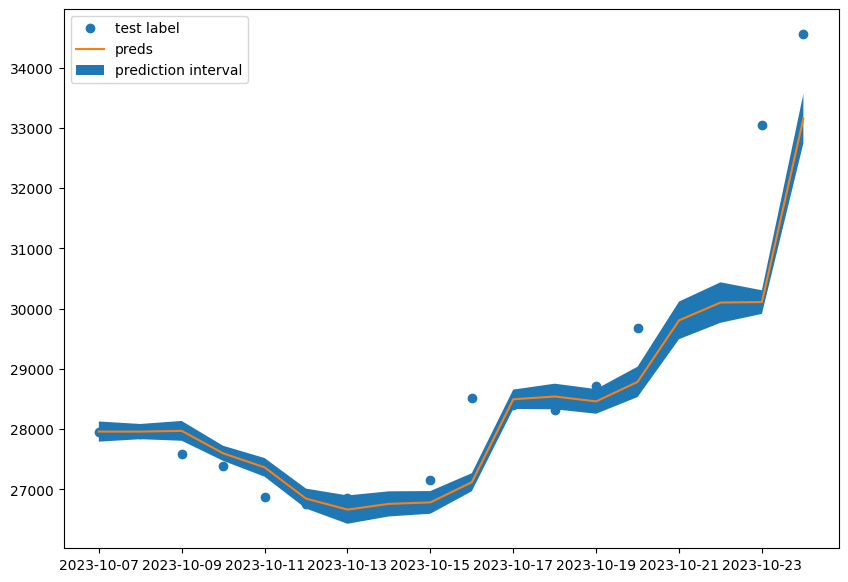

In [231]:
offset = 950
plt.figure(figsize=(10, 7))
plt.plot(test_labels.index[offset:], test_labels.values[offset:], 'o', label='test label')
plt.plot(test_labels.index[offset:], ens_mean[offset:], '-', label='preds')

plt.fill_between(test_labels.index[offset:], (lower)[offset:], (upper)[offset:], label='prediction interval')
plt.legend(loc='upper left')

Types of uncertainty

- Aleatoric uncertainty (data or subway uncertainty): it cannot be reduced with more data. No matter how much data we collect we cannot reduce this uncertainty.

- Epistemic uncertainty (model or coconut uncertainty): which can be reduced with more data. Describe the confidence in the prediction

### Make prediction into the future

Train the model on the full historical data to make predictions into the future.

NB: you need to retrain the model every time you want to generate a new prediction

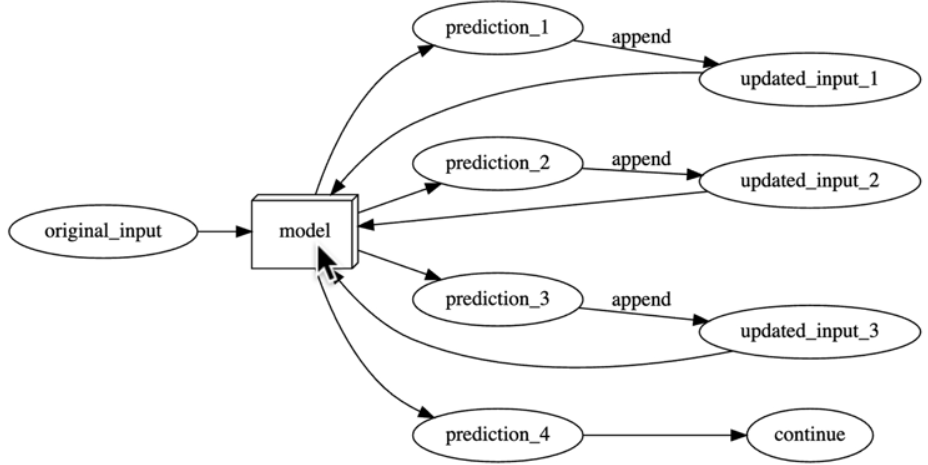

In [232]:
# Make features and labels
x = bitcoin_prices_nbeats.dropna().drop('Price', axis=1)
y = bitcoin_prices_nbeats.dropna()['Price']

In [233]:
# TIme to make our dataset performant using tf.data API
features_dataset = tf.data.Dataset.from_tensor_slices(x)
labels_dataset = tf.data.Dataset.from_tensor_slices(y)
# combine labels and features by zipping together (features, labels)
dataset = tf.data.Dataset.zip((features_dataset, labels_dataset))

# Batching and prefech
BATCH_SIZE = 1024
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [236]:
# set random seed for as reproductible results as possible
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON)
], name='model_6')

model_6.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae', 'mse']
)

history_6 = model_6.fit(
    dataset,
    epochs=100,
    verbose=0
)

#### Make predictions into future

To make predictions into the future we want a function which:

1- Take as input:
    - a list of values (Bitcoin historical data)
    - a trained model
    - a window into the future to predict (`our INTO_FUTURE var`)
    - the window size a model was trained on

2- create an empty list for future forecasts. this will be returned at the end when it's full of predictions and extract the last window_size(here 7) values from the inputs values

3- Loop `INTO_FUTURE` times making a prediction on `window_size` sequences which update to remove the first value and append the latest prediction

In [243]:
INTO_FUTURE = 14
def make_future_prediction(values, model, into_future=INTO_FUTURE, window_size=WINDOW_SISE) -> list:
    """
    Make future forecasts into_fture steps after values ends
    Return:
        future firecasts as a list of float
    """
    # create an empty list for future forecasts
    future_forecast = []
    last_window = values[-window_size:]
    # Make into_future number of predictions, altering the data which gets predicted on each
    for _ in range(into_future):
        # predict on the last window then append it again, again, again
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f'Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()} \n')
        
        # Append predictions
        future_forecast.append(tf.squeeze(future_pred).numpy()) 
        # Upadate last window with new pred and get WINDOW_SIZE most recent
        last_window = np.append(last_window, future_pred)[-window_size:]
    return future_forecast

In [245]:
future_forecasts = make_future_prediction(y.values, model_6)

1/1 [==============================] - 0s 24ms/step
Predicting on: 
 [28321.7 28723.  29674.5 29912.9 29984.2 33041.8 34562.9] -> Prediction: 28932.146484375 

1/1 [==============================] - 0s 31ms/step
Predicting on: 
 [28723.         29674.5        29912.9        29984.2
 33041.8        34562.9        28932.14648438] -> Prediction: 29653.29296875 

1/1 [==============================] - 0s 19ms/step
Predicting on: 
 [29674.5        29912.9        29984.2        33041.8
 34562.9        28932.14648438 29653.29296875] -> Prediction: 30442.962890625 

1/1 [==============================] - 0s 19ms/step
Predicting on: 
 [29912.9        29984.2        33041.8        34562.9
 28932.14648438 29653.29296875 30442.96289062] -> Prediction: 30597.560546875 

1/1 [==============================] - 0s 21ms/step
Predicting on: 
 [29984.2        33041.8        34562.9        28932.14648438
 29653.29296875 30442.96289062 30597.56054688] -> Prediction: 31566.783203125 

1/1 [=================

In [267]:
def get_future_dates(start_date, into_future=INTO_FUTURE, offset=1):
    """
    Return an array of datetime values ranging from start_date to start_date + into_future.

    Parameters:
    start_date (datetime): Starting date.
    into_future (int): Number of days into the future, default is 7.
    offset (int): Offset from the start_date, default is 1 day.

    Returns:
    numpy.ndarray: Array of dates from start_date + offset to start_date + into_future.
    """
    # Ensure start_date is a numpy datetime64 object
    start_date = np.datetime64(start_date)

    # Calculate the start date with offset and end date
    start_date_with_offset = start_date + np.timedelta64(offset, 'D')  # 'D' stands for day
    end_date = start_date_with_offset + np.timedelta64(into_future, 'D')

    # Generate and return the range of dates
    return np.arange(start_date_with_offset, end_date, dtype='datetime64[D]')

future_dates = get_future_dates(y.index[-1])


In [275]:
future_dates = np.insert(future_dates, 0, y.index[-1])
future_forecasts = np.insert(future_forecasts, 0, y.values[-1])

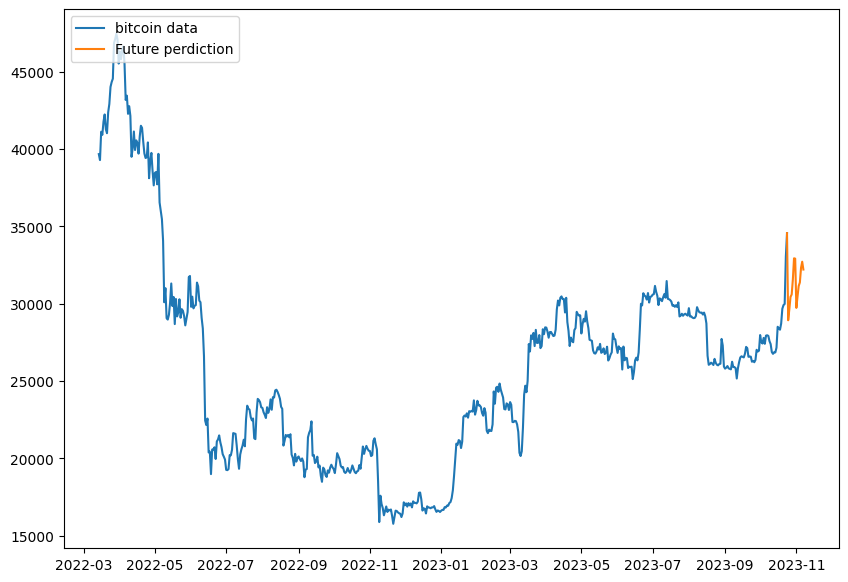

In [276]:
offset = 4250
plt.figure(figsize=(10, 7))
plt.plot(y.index[offset:], y.values[offset:], '-', label='bitcoin data')
plt.plot(future_dates, future_forecasts, '-', label='Future perdiction')
plt.legend(loc='upper left')

In [298]:
# results = pd.DataFrame(pd.Series(np.expand_dims(model_1_results.values(), axis=0), index=['horizon=1, window_size=7, Dense, univariate']), columns=model_1_results.keys())
results = pd.DataFrame.from_dict(model_1_results, orient='index', columns=['horizon=1, window_size=7, Dense, univariate'])
results_1 = pd.DataFrame.from_dict(model_2_res, orient='index', columns=['horizon=1, window_size=7, conv1D, univariate'])
results_2 = pd.DataFrame.from_dict(model_3_res, orient='index', columns=['horizon=1, window_size=7, Dense, multivariate'])
results_3 = pd.DataFrame.from_dict(nbeats_res, orient='index', columns=['horizon=1, window_size=7, NBeats algo, univariate'])
results_4 = pd.DataFrame.from_dict(ens_res, orient='index', columns=['horizon=1, window_size=7, Ensemble, univariate'])
results = pd.concat([results, results_1, results_2, results_3, results_4], axis=1)
results

,"horizon=1, window_size=7, Dense, univariate","horizon=1, window_size=7, conv1D, univariate","horizon=1, window_size=7, Dense, multivariate","horizon=1, window_size=7, NBeats algo, univariate","horizon=1, window_size=7, Ensemble, univariate"
mae,8.194720e+02,1.468349e+04,416.776337,8.265875e+02,8.280799e+02
mse,1.620772e+06,3.408884e+08,364025.000000,1.630284e+06,1.627460e+06
rmse,1.273095e+03,1.788456e+04,603.344849,1.276826e+03,1.275719e+03
mape,2.283613e+00,4.756548e+01,1.165349,2.299408e+00,2.306975e+00
mase,4.200800e+01,4.200800e+01,42.007999,4.200800e+01,4.200800e+01
